In [97]:
import pandas as pd
import geopandas
import random
#from shapely.strtree import STRtree
from shapely.geometry import MultiPolygon
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import copy

In [2]:
initial_solution_df = pd.read_pickle('solutions_example.pkl')

initial_solution_df.to_csv('solutions_example.csv')

In [3]:
lsoa_geojson_path = 'https://github.com/hsma-programme/h6_3c_interactive_plots_travel/raw/main/h6_3c_interactive_plots_travel/example_code/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4.geojson'

lsoa_boundaries = geopandas.read_file(lsoa_geojson_path)

xmin, xmax = 370000, 420000
ymin, ymax = 250000, 310000

bham_region = lsoa_boundaries.cx[xmin:xmax, ymin:ymax]

bham_region["region"] = bham_region["LSOA11NM"].str[:-5]

boundary_allocations_df = pd.read_csv("boundary_allocations.csv")

bham_region = pd.merge(
    bham_region,
    boundary_allocations_df,
    left_on="region",
    right_on="Region",
    how="left"
)

bham_region["centre_dispatcher"] = bham_region["Centre"].astype("str") + '-' + bham_region["Dispatcher"].astype("str")

demand = pd.read_csv("demand_pop_bham.csv")

bham_region = bham_region.merge(demand, on="LSOA11CD")

# Create df of original boundaries
grouped_dispatcher_gdf = bham_region.groupby("centre_dispatcher")

# Create a new GeoDataFrame for the boundaries of each group
boundary_list = []

for group_name, group in grouped_dispatcher_gdf:
    # Combine the polygons in each group into one geometry
    combined_geometry = group.unary_union

    # Get the boundary of the combined geometry
    boundary = combined_geometry.boundary

    # Add the boundary geometry and the group name to the list
    boundary_list.append({'group': group_name, 'boundary': boundary})

# Create a GeoDataFrame from the list of boundaries
grouped_dispatcher_gdf_boundary = geopandas.GeoDataFrame(boundary_list, geometry='boundary', crs=bham_region.crs)


/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
def extract_allocation_df_from_solution_df(df, solution_rank, allocation_col_name, territory_col_name):
    row_of_interest = df[df['rank'] == solution_rank]
    owned_territory_dict = row_of_interest['allocations'].values[0]

    owned_territory_df = pd.DataFrame(
            [(key, value) for key, values in owned_territory_dict.items() for value in values],
            columns=[allocation_col_name, territory_col_name])
    return owned_territory_df

In [5]:
best_solution = extract_allocation_df_from_solution_df(
    initial_solution_df,
    solution_rank=1,
    allocation_col_name="centre_dispatcher_NEW",
    territory_col_name="LSOA11CD"
    )

best_solution

,centre_dispatcher_NEW,LSOA11CD
0,Centre 2-5,E01031187
1,Centre 2-5,E01031195
2,Centre 2-5,E01031217
3,Centre 2-5,E01031204
4,Centre 2-5,E01031213
...,...,...
2006,Centre 2-2,E01009724
2007,Centre 2-2,E01009720
2008,Centre 2-2,E01009723
2009,Centre 2-2,E01009725


Visualise the historical boundaries against our best solution

<Axes: >

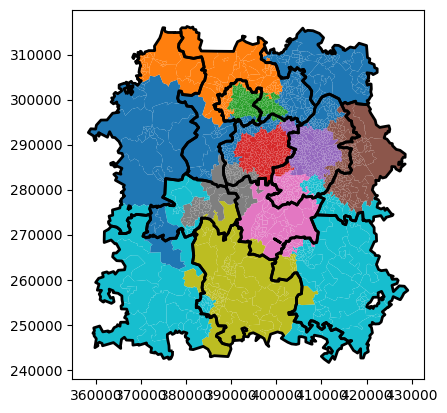

In [6]:
ax=bham_region.merge(best_solution, on="LSOA11CD").plot(column="centre_dispatcher_NEW")

# Visualise the historical boundaries
grouped_dispatcher_gdf_boundary.plot(
    ax=ax,
    linewidth=2,
    edgecolor="black"
)

In [11]:
def create_boundary_df_by_dispatcher(region_df, solution_df,
                                     region_df_merge_col, solution_df_merge_col,
                                     grouping_col):
    # Create df of original boundaries
    grouped_dispatcher_gdf_starting_solution = (
        region_df.merge(solution_df, on="LSOA11CD")
        .groupby(grouping_col)
        )

    # Create a new GeoDataFrame for the boundaries of each group
    boundary_list = []

    for group_name, group in grouped_dispatcher_gdf_starting_solution:
        # Combine the polygons in each group into one geometry
        combined_geometry = group.unary_union

        # Get the boundary of the combined geometry
        boundary = combined_geometry.boundary

        # Add the boundary geometry and the group name to the list
        boundary_list.append({'group': group_name, 'boundary': boundary})

    # Create a GeoDataFrame from the list of boundaries
    return geopandas.GeoDataFrame(boundary_list, geometry='boundary', crs=bham_region.crs)

<Axes: >

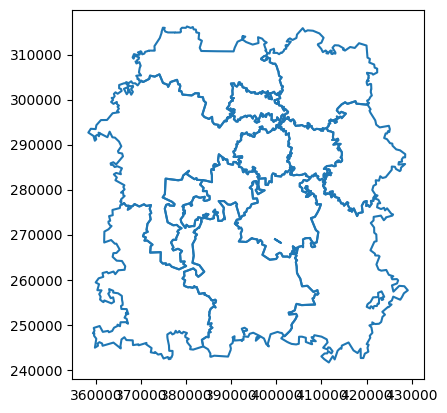

In [13]:
grouped_dispatcher_gdf_starting_solution = create_boundary_df_by_dispatcher(
    region_df=bham_region,
    solution_df=best_solution,
    region_df_merge_col="LSOA11CD",
    solution_df_merge_col="LSOA11CD",
    grouping_col="centre_dispatcher_NEW"
    )

grouped_dispatcher_gdf_starting_solution.plot()

<Axes: >

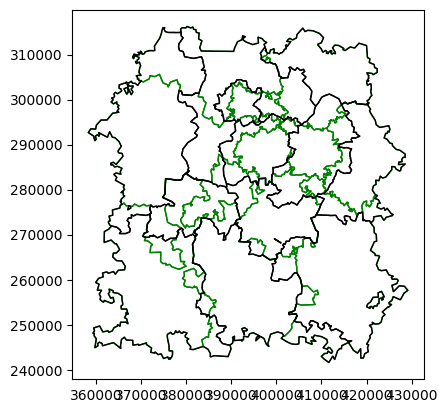

In [16]:
ax = grouped_dispatcher_gdf_starting_solution.plot(
    linewidth=1,
    edgecolor="green"
)

grouped_dispatcher_gdf_boundary.plot(
    ax=ax,
    linewidth=1,
    edgecolor="black"
)

## EA Functions

### Augmenting the dataframe with required information - used once

In [7]:
def add_neighbors_column(gdf):
    """
    Adds a column to the GeoDataFrame containing lists of indices of neighboring polygons
    based on the 'touches' method.
    """
    gdf = gdf.copy()
    neighbors = []
    for idx, geom in gdf.geometry.items():
        touching = gdf[gdf.geometry.touches(geom)]["LSOA11CD"].tolist()
        neighbors.append(touching)

    gdf["neighbors"] = neighbors
    return gdf

def find_border_dispatchers(row, df, allocation_colname='centre_dispatcher_NEW'):
    current_dispatcher = row[allocation_colname]
    neighbors = row['neighbors']

    # Get dispatchers of neighboring LSOAs
    neighboring_dispatchers = {
        df.loc[df['LSOA11CD'] == neighbor, allocation_colname].values[0]
        for neighbor in neighbors if not df[df['LSOA11CD'] == neighbor].empty
    }

    # Filter to only different dispatchers
    border_dispatchers = list(neighboring_dispatchers - {current_dispatcher})

    return border_dispatchers if border_dispatchers else []

In [ ]:
def is_solution_continuous(solution_gdf, allocation_col):
    """
    Uses spatial indexing to quickly check if dispatchers have disjoint regions.
    """

    # Dissolve regions by dispatcher
    dispatcher_groups = solution_gdf.dissolve(by=allocation_col)

    for geom in dispatcher_groups.geometry:
        if isinstance(geom, MultiPolygon):
            # Check if all parts of MultiPolygon touch each other
            parts = list(geom.geoms)  # Extract individual polygons
            for i in range(len(parts)):
                if not any(parts[i].touches(parts[j]) for j in range(len(parts)) if i != j):
                    return False  # Found a fully disconnected part

    return True

def is_continuous_after_swap(solution_gdf, lsoa,
                             current_dispatcher,
                             proposed_dispatcher,
                             allocation_col):
    """
    Checks if assigning 'lsoa' to 'new_dispatcher' maintains contiguous regions.
    This version avoids making a full DataFrame copy.
    """
    # Temporarily assign new dispatcher
    solution_gdf.loc[solution_gdf["LSOA11CD"] == lsoa, allocation_col] = proposed_dispatcher

    # Check continuity
    is_valid = is_solution_continuous(solution_gdf, allocation_col)

    # Revert change immediately (avoiding full copy overhead)
    solution_gdf.loc[solution_gdf["LSOA11CD"] == lsoa, allocation_col] = current_dispatcher

    return is_valid
    #return True

def assign_new_dispatcher(row,
                          solution_gdf,
                          border_colname,
                          permutation_chance_per_border,
                          new_allocation_colname
                          ):
        """
        Attempts to assign a new dispatcher while keeping the solution continuous.
        """

        # If no bordering dispatchers, keep the original
        if not row[border_colname]:
            print(f'No borders in {row["LSOA11CD"]}')
            return row[new_allocation_colname]

        # If some bordering dispatchers, then randomly sample whether we will try to permute it
        elif random.uniform(0.0, 1.0) < permutation_chance_per_border:

            # Randomly select from border dispatchers
            current_dispatcher = row[new_allocation_colname]
            random_dispatcher = random.choice(row[border_colname])

            # Check if assigning this dispatcher keeps the solution contiguous
            if is_continuous_after_swap(solution_gdf,
                                        lsoa = row["LSOA11CD"],
                                        current_dispatcher=current_dispatcher,
                                        proposed_dispatcher=random_dispatcher,
                                        allocation_col=new_allocation_colname):
                print(f"*** Swapped {row['LSOA11CD']} to {random_dispatcher} ***")
                return random_dispatcher
            else:
                print(f":( Tried{row['LSOA11CD']} from {current_dispatcher} to {random_dispatcher}")
                return row[new_allocation_colname]  # Default to original allocation
        else:
            print(f"Not trying to permute {row['LSOA11CD']}")
            return row[new_allocation_colname]

## EA Function

In [63]:
def create_evolved_solutions(
        initial_solution_df, geodataframe,
        join_col_left, join_col_right,
        original_allocation_colname='centre_dispatcher',
        random_solution_allocation_colname='centre_dispatcher_NEW',
        new_allocation_colname='centre_dispatcher_evolved',
        border_colname='border_dispatchers',
        permutation_chance_per_border=0.2,
        population_size=1
    ):
    """
    Generates evolved dispatcher allocations while ensuring that all regions remain contiguous.
    """

    # Merge initial solution with geodataframe to keep it as a geodataframe
    initial_solution_gdf = geodataframe.merge(initial_solution_df, left_on=join_col_left, right_on=join_col_right)

    # Compute neighbors and border dispatchers
    initial_solution_gdf = add_neighbors_column(initial_solution_gdf)
    initial_solution_gdf[border_colname] = initial_solution_gdf.apply(
        find_border_dispatchers, axis=1, df=initial_solution_gdf
        )

    # new_allocation_dfs = []

    # Include new_allocation_colname from the start
    simplified_allocation_df = (
        initial_solution_gdf[
            [random_solution_allocation_colname, 'LSOA11CD', border_colname, "geometry"]
            ].copy()
            )

    simplified_allocation_df[new_allocation_colname] = (
        simplified_allocation_df[random_solution_allocation_colname]
        )

    def process_iteration(i, simplified_allocation_df, border_colname,
                     permutation_chance_per_border, new_allocation_colname):

        # for i in range(population_size):
        evolved_df = simplified_allocation_df.copy(deep=True)

        # Separate out the cols with and without borders
        non_borders_df = evolved_df[evolved_df[border_colname].apply(len) == 0]
        borders_df = evolved_df[evolved_df[border_colname].apply(len) > 0]
        print(f"{len(non_borders_df)} regions without borders and {len(borders_df)} with borders")

        borders_df[new_allocation_colname] = borders_df.apply(
            lambda row: assign_new_dispatcher(
                row, borders_df,
                border_colname,
                permutation_chance_per_border,
                new_allocation_colname
                ), axis=1)

        return pd.concat([non_borders_df, borders_df], ignore_index=True)

        # evolved_df = pd.concat([non_borders_df, borders_df], ignore_index=True)

        #new_allocation_dfs.append(evolved_df.copy(deep=True))

        del evolved_df, non_borders_df, borders_df

    return Parallel(n_jobs=-1, verbose=10)(
            delayed(process_iteration)(
                i,
                simplified_allocation_df,
                border_colname,
                permutation_chance_per_border,
                new_allocation_colname
            )
            for i in range(population_size)
        )


## Test EA Function

### Generate one permutation

In [64]:
solution = create_evolved_solutions(
    best_solution,
    bham_region,
    join_col_left="LSOA11CD",
    join_col_right="LSOA11CD",
    population_size=1
)

solution[0]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


1342 regions without borders and 669 with borders
Not trying to permute E01008881
Not trying to permute E01008882
*** Swapped E01008883 to Centre 1-6 ***
Not trying to permute E01008884
Not trying to permute E01008885
Not trying to permute E01008886
:( TriedE01008887 from Centre 1-7 to Centre 1-6
:( TriedE01008889 from Centre 1-6 to Centre 1-7
Not trying to permute E01008890
Not trying to permute E01008892
Not trying to permute E01008894
Not trying to permute E01008897
Not trying to permute E01008918
Not trying to permute E01008919
*** Swapped E01008921 to Centre 1-5 ***
Not trying to permute E01008925
*** Swapped E01008927 to Centre 1-5 ***
Not trying to permute E01008931
Not trying to permute E01008942
Not trying to permute E01008943
Not trying to permute E01008946
Not trying to permute E01008947
*** Swapped E01008949 to Centre 2-5 ***
Not trying to permute E01008952
*** Swapped E01008953 to Centre 2-1 ***
Not trying to permute E01008955
Not trying to permute E01008957
Not trying to 

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s


,centre_dispatcher_NEW,LSOA11CD,border_dispatchers,geometry,centre_dispatcher_evolved
0,Centre 1-7,E01008888,[],"POLYGON ((413420.692 284795.501, 413826.348 28...",Centre 1-7
1,Centre 1-7,E01008891,[],"POLYGON ((413031.049 284196.638, 413321.825 28...",Centre 1-7
2,Centre 1-7,E01008893,[],"POLYGON ((412949.766 283625.900, 412594.358 28...",Centre 1-7
3,Centre 1-7,E01008895,[],"POLYGON ((413166.349 283295.822, 413132.000 28...",Centre 1-7
4,Centre 1-6,E01008896,[],"POLYGON ((412405.000 286300.615, 412535.675 28...",Centre 1-6
...,...,...,...,...,...
2006,Centre 1-6,E01033562,"[Centre 1-5, Centre 2-1]","POLYGON ((404432.818 284070.885, 404516.073 28...",Centre 1-6
2007,Centre 1-6,E01033631,[Centre 2-1],"POLYGON ((405950.078 285312.998, 405575.210 28...",Centre 1-6
2008,Centre 2-1,E01033634,[Centre 1-6],"POLYGON ((404873.774 282636.291, 404623.886 28...",Centre 2-1
2009,Centre 1-6,E01033641,[Centre 1-7],"POLYGON ((410005.374 283902.287, 410505.181 28...",Centre 1-7


(354661.51608, 432721.98692000005, 237880.94981, 319973.24779)

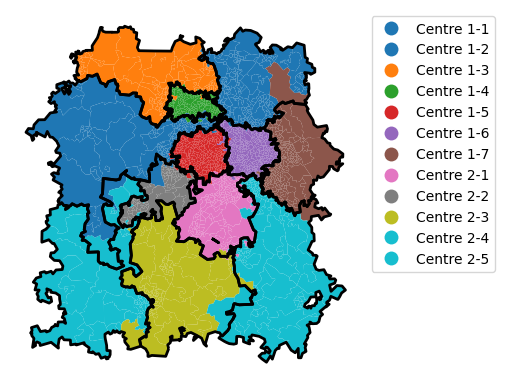

In [65]:
#| label: plot-single-solution

ax = solution[0].plot(column="centre_dispatcher_evolved", legend=True,
                      legend_kwds={'bbox_to_anchor': (1.4, 1)})

# Plot historical boundaries
grouped_dispatcher_gdf_starting_solution.plot(ax=ax, linewidth=2, edgecolor="black")

ax.axis("off")  # Hide axes for better visualization

### Generate more permutations

In [66]:
solution = create_evolved_solutions(
    best_solution,
    bham_region,
    join_col_left="LSOA11CD",
    join_col_right="LSOA11CD",
    population_size=30
)

solution[25]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


1342 regions without borders and 669 with borders
Not trying to permute E01008881
Not trying to permute E01008882
Not trying to permute E01008883
Not trying to permute E01008884
Not trying to permute E01008885
1342 regions without borders and 669 with borders
Not trying to permute E01008881
Not trying to permute E01008882
Not trying to permute E01008883
Not trying to permute E01008884
Not trying to permute E01008885
Not trying to permute E01008886
Not trying to permute E01008887
:( TriedE01008886 from Centre 1-7 to Centre 1-6
:( TriedE01008889 from Centre 1-6 to Centre 1-7
Not trying to permute E01008890
Not trying to permute E01008892
Not trying to permute E01008894
Not trying to permute E01008897
Not trying to permute E01008918
1342 regions without borders and 669 with borders
Not trying to permute E01008881
Not trying to permute E01008882
Not trying to permute E01008883
:( TriedE01008887 from Centre 1-7 to Centre 1-6
Not trying to permute E01008889
1342 regions without borders and 6

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01010497 to Centre 1-3 ***
*** Swapped E01032258 to Centre 2-1 ***
*** Swapped E01032191 to Centre 2-4 ***
Not trying to permute E01032192
Not trying to permute E01032193
Not trying to permute E01032199
Not trying to permute E01032205
Not trying to permute E01032206
Not trying to permute E01032212
Not trying to permute E01032223
Not trying to permute E01032227
Not trying to permute E01032228
Not trying to permute E01032229
Not trying to permute E01032230
Not trying to permute E01032231
Not trying to permute E01032236
Not trying to permute E01032237
Not trying to permute E01032238
Not trying to permute E01032239
Not trying to permute E01032241
Not trying to permute E01032242
Not trying to permute E01032243
Not trying to permute E01032244
:( TriedE01010219 from Centre 2-5 to Centre 1-7
:( TriedE01029633 from Centre 1-3 to Centre 1-4
Not trying to permute E01029638
Not trying to permute E01029641
Not trying to permute E01029642
Not trying to permute E01029644
Not trying to pe

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


:( TriedE01010498 from Centre 1-3 to Centre 1-4*** Swapped E01032274 to Centre 2-1 ***
Not trying to permute E01032275
Not trying to permute E01032276
Not trying to permute E01032279
Not trying to permute E01032280
Not trying to permute E01032281
Not trying to permute E01032282
Not trying to permute E01032283
Not trying to permute E01032284

*** Swapped E01010381 to Centre 1-3 ***
Not trying to permute E01010382
Not trying to permute E01010393
Not trying to permute E01010394
:( TriedE01010220 from Centre 2-5 to Centre 1-7
Not trying to permute E01010223
Not trying to permute E01010225
Not trying to permute E01010263
Not trying to permute E01010264
:( TriedE01029621 from Centre 1-3 to Centre 1-2
Not trying to permute E01029632
:( TriedE01032392 from Centre 2-3 to Centre 2-5
:( TriedE01031281 from Centre 2-5 to Centre 1-7
1342 regions without borders and 669 with borders
Not trying to permute E01008881
Not trying to permute E01008882
:( TriedE01031023 from Centre 1-7 to Centre 1-2
Not tr

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   11.6s remaining:  1.7min
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is

*** Swapped E01014118 to Centre 1-3 ***
Not trying to permute E01028826
Not trying to permute E01028828
:( TriedE01031186 from Centre 2-5 to Centre 2-3
Not trying to permute E01031189
Not trying to permute E01031191
Not trying to permute E01031208
*** Swapped E01009043 to Centre 1-7 ***
Not trying to permute E01009045
Not trying to permute E01009046
Not trying to permute E01009065
Not trying to permute E01009066
Not trying to permute E01009067
Not trying to permute E01009068
Not trying to permute E01009069
Not trying to permute E01009071
Not trying to permute E01009072
Not trying to permute E01009073
Not trying to permute E01009074
:( TriedE01028826 from Centre 1-3 to Centre 1-1
Not trying to permute E01028828
Not trying to permute E01028847
Not trying to permute E01028849
Not trying to permute E01028855
Not trying to permute E01028858
Not trying to permute E01029001
Not trying to permute E01029359
:( TriedE01010470 from Centre 1-4 to Centre 1-3Not trying to permute E01029360
Not tryin

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   12.4s remaining:   40.8s


:( TriedE01008976 from Centre 2-5 to Centre 2-1
Not trying to permute E01008977
Not trying to permute E01008978
Not trying to permute E01008979
:( TriedE01009134 from Centre 1-2 to Centre 1-6
*** Swapped E01032262 to Centre 2-5 ***
Not trying to permute E01032263
Not trying to permute E01032264
Not trying to permute E01032271
*** Swapped E01008979 to Centre 2-5 ***
Not trying to permute E01008980
Not trying to permute E01008992
Not trying to permute E01009001
Not trying to permute E01009003
Not trying to permute E01009005
*** Swapped E01032275 to Centre 2-1 ***
Not trying to permute E01032276
Not trying to permute E01032279
Not trying to permute E01032280
Not trying to permute E01032281
Not trying to permute E01032282
Not trying to permute E01032283
1342 regions without borders and 669 with borders
:( TriedE01032206 from Centre 2-4 to Centre 2-3
Not trying to permute E01008881
Not trying to permute E01008882
Not trying to permute E01008883
Not trying to permute E01008884
Not trying to 

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


:( TriedE01009040 from Centre 2-5 to Centre 1-7
Not trying to permute E01009041
Not trying to permute E01009042
Not trying to permute E01009043
:( TriedE01032190 from Centre 2-3 to Centre 2-4
Not trying to permute E01032191
:( TriedE01032279 from Centre 2-3 to Centre 2-4
Not trying to permute E01032280
Not trying to permute E01032281
Not trying to permute E01032282
Not trying to permute E01032283
Not trying to permute E01032284
Not trying to permute E01032285
Not trying to permute E01032288
Not trying to permute E01032289
Not trying to permute E01032292
Not trying to permute E01032294
Not trying to permute E01032295
Not trying to permute E01032296
Not trying to permute E01032300
*** Swapped E01032229 to Centre 2-5 ***
Not trying to permute E01032230
Not trying to permute E01032231
Not trying to permute E01032236
:( TriedE01008967 from Centre 2-5 to Centre 2-1
Not trying to permute E01008970
:( TriedE01032123 from Centre 2-1 to Centre 2-5
:( TriedE01008943 from Centre 2-5 to Centre 2-1


/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01032274 to Centre 2-1 ***
*** Swapped E01032482 to Centre 2-2 ***
Not trying to permute E01032590
Not trying to permute E01032591
Not trying to permute E01032592
Not trying to permute E01032886
*** Swapped E01009248 to Centre 1-2 ***
:( TriedE01010510 from Centre 1-3 to Centre 1-4
Not trying to permute E01010511
Not trying to permute E01010512
Not trying to permute E01010513
Not trying to permute E01010514
Not trying to permute E01010516
Not trying to permute E01010517
Not trying to permute E01010518
Not trying to permute E01010519
Not trying to permute E01010520
Not trying to permute E01010522
Not trying to permute E01010523
Not trying to permute E01010524
Not trying to permute E01010525
Not trying to permute E01010527
Not trying to permute E01010533
Not trying to permute E01010535
Not trying to permute E01010536
Not trying to permute E01010539
Not trying to permute E01010542
Not trying to permute E01010545
Not trying to permute E01010554
Not trying to permute E01010555


/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   14.4s remaining:   24.9s


:( TriedE01009188 from Centre 2-5 to Centre 1-6
Not trying to permute E01009222
Not trying to permute E01009223
Not trying to permute E01009224
Not trying to permute E01009225
Not trying to permute E01009226
Not trying to permute E01009227
Not trying to permute E01009228
Not trying to permute E01009230
Not trying to permute E01009231
Not trying to permute E01009243
Not trying to permute E01009245
Not trying to permute E01009248
*** Swapped E01009385 to Centre 2-5 ***
Not trying to permute E01009389
Not trying to permute E01009390
Not trying to permute E01009392
Not trying to permute E01009394
Not trying to permute E01009395
Not trying to permute E01009403
Not trying to permute E01009404
Not trying to permute E01009416
*** Swapped E01009272 to Centre 1-5 ***
Not trying to permute E01009282
Not trying to permute E01009283
Not trying to permute E01009284
Not trying to permute E01009288
Not trying to permute E01009296
Not trying to permute E01009298
1342 regions without borders and 669 wit

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


:( TriedE01032283 from Centre 2-3 to Centre 2-4
Not trying to permute E01032284
Not trying to permute E01032285
Not trying to permute E01032288
Not trying to permute E01032289
Not trying to permute E01032292
Not trying to permute E01032294
Not trying to permute E01032295
Not trying to permute E01032296
Not trying to permute E01032300
:( TriedE01008971 from Centre 2-5 to Centre 2-1
Not trying to permute E01008972
Not trying to permute E01008973
:( TriedE01009306 from Centre 1-7 to Centre 1-6
*** Swapped E01008921 to Centre 1-5 ***
Not trying to permute E01008925
Not trying to permute E01008927
*** Swapped E01029364 to Centre 1-2 ***
Not trying to permute E01029365
Not trying to permute E01029395
Not trying to permute E01029488
*** Swapped E01032136 to Centre 2-1 ***
Not trying to permute E01032137
Not trying to permute E01032141
Not trying to permute E01032145
Not trying to permute E01032146
Not trying to permute E01032147
Not trying to permute E01032166
:( TriedE01009471 from Centre 1-

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01032446 to Centre 2-4 ***
Not trying to permute E01032448
Not trying to permute E01032451
Not trying to permute E01032452
Not trying to permute E01032453
:( TriedE01032280 from Centre 2-4 to Centre 2-3
*** Swapped E01009403 to Centre 1-6 ***
Not trying to permute E01009404
Not trying to permute E01009416
Not trying to permute E01009432
Not trying to permute E01009435
Not trying to permute E01009437
*** Swapped E01008992 to Centre 1-5 ***
Not trying to permute E01009001
Not trying to permute E01009003
Not trying to permute E01009005
Not trying to permute E01009009
Not trying to permute E01009011
Not trying to permute E01009014
:( TriedE01009451 from Centre 1-2 to Centre 1-7
Not trying to permute E01009452
*** Swapped E01032275 to Centre 2-1 ***
Not trying to permute E01032276
Not trying to permute E01032279
Not trying to permute E01032280
Not trying to permute E01032281
:( TriedE01009187 from Centre 2-5 to Centre 1-6
Not trying to permute E01009188
Not trying to permute E0

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   15.9s remaining:   15.9s


*** Swapped E01032433 to Centre 2-3 ***
Not trying to permute E01032435
Not trying to permute E01032436
Not trying to permute E01032437
Not trying to permute E01032438
*** Swapped E01032247 to Centre 2-5 ***
Not trying to permute E01032248
Not trying to permute E01032249
Not trying to permute E01032251
Not trying to permute E01032256
Not trying to permute E01032257
Not trying to permute E01032258
*** Swapped E01009991 to Centre 1-1 ***
Not trying to permute E01009994
Not trying to permute E01009995
*** Swapped E01032419 to Centre 2-3 ***
Not trying to permute E01032420
Not trying to permute E01032421
Not trying to permute E01032422
Not trying to permute E01032428
Not trying to permute E01032430
*** Swapped E01009514 to Centre 1-7 ***
Not trying to permute E01009515
Not trying to permute E01009516
Not trying to permute E01009517
Not trying to permute E01009518
*** Swapped E01032394 to Centre 2-5 ***
Not trying to permute E01032395
Not trying to permute E01032404
*** Swapped E01009045 to

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01010099 to Centre 1-5 ***
:( TriedE01009458 from Centre 1-2 to Centre 1-6
Not trying to permute E01009459
*** Swapped E01032453 to Centre 2-2 ***
Not trying to permute E01032456
Not trying to permute E01032457
Not trying to permute E01032458
Not trying to permute E01032459
Not trying to permute E01032460
:( TriedE01009451 from Centre 1-2 to Centre 1-7
*** Swapped E01009966 to Centre 1-5 ***
Not trying to permute E01009967
*** Swapped E01032443 to Centre 2-4 ***
Not trying to permute E01032445
Not trying to permute E01032446
Not trying to permute E01032448
Not trying to permute E01032451
:( TriedE01032300 from Centre 2-3 to Centre 2-4
Not trying to permute E01032302
*** Swapped E01009737 to Centre 2-2 ***
*** Swapped E01010064 to Centre 1-6 ***
Not trying to permute E01010065
Not trying to permute E01010068
Not trying to permute E01010070
Not trying to permute E01010074
Not trying to permute E01010076
*** Swapped E01009119 to Centre 2-5 ***
Not trying to permute E01009121


/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01010011 to Centre 1-2 ***
Not trying to permute E01010029
Not trying to permute E01010031
Not trying to permute E01010033
Not trying to permute E01010037
Not trying to permute E01010046
Not trying to permute E01010052
Not trying to permute E01010059
:( TriedE01010206 from Centre 1-7 to Centre 2-5
Not trying to permute E01010207
Not trying to permute E01010208
Not trying to permute E01010209
Not trying to permute E01010212
Not trying to permute E01010214
Not trying to permute E01010216
Not trying to permute E01010219
Not trying to permute E01010220
Not trying to permute E01010223
Not trying to permute E01010225
*** Swapped E01010099 to Centre 1-5 ***
Not trying to permute E01010100
Not trying to permute E01010101
Not trying to permute E01010108
Not trying to permute E01010115
Not trying to permute E01010122
Not trying to permute E01010150
Not trying to permute E01010151
Not trying to permute E01010153
Not trying to permute E01010167
Not trying to permute E01010181
*** Swap

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01009732 to Centre 1-5 ***
Not trying to permute E01009733
Not trying to permute E01009737
Not trying to permute E01009738
Not trying to permute E01009739
*** Swapped E01009950 to Centre 1-5 ***
*** Swapped E01009258 to Centre 2-1 ***
Not trying to permute E01009954
Not trying to permute E01009960
Not trying to permute E01009259
Not trying to permute E01009272
Not trying to permute E01009282
:( TriedE01010098 from Centre 1-1 to Centre 1-5
Not trying to permute E01010099
*** Swapped E01009799 to Centre 2-1 ***
Not trying to permute E01009802
Not trying to permute E01009804
:( TriedE01010216 from Centre 2-5 to Centre 1-7
Not trying to permute E01010219
*** Swapped E01009781 to Centre 1-5 ***
Not trying to permute E01009785
Not trying to permute E01009786
Not trying to permute E01009787
*** Swapped E01010273 to Centre 1-3 ***
Not trying to permute E01010274
Not trying to permute E01010275
Not trying to permute E01010277
Not trying to permute E01010282
:( TriedE01010206 from C

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   17.5s remaining:   10.2s
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01010068 to Centre 1-5 ***
*** Swapped E01010284 to Centre 1-2 ***
Not trying to permute E01010286
Not trying to permute E01010289
Not trying to permute E01010290
Not trying to permute E01010292
Not trying to permute E01010294
Not trying to permute E01010295
Not trying to permute E01010309
Not trying to permute E01010310
Not trying to permute E01010311
Not trying to permute E01010312
Not trying to permute E01010313
Not trying to permute E01010314
Not trying to permute E01010315
Not trying to permute E01010330
Not trying to permute E01010332
Not trying to permute E01010334
Not trying to permute E01010335
Not trying to permute E01010336
Not trying to permute E01010337
Not trying to permute E01010338
Not trying to permute E01010339
Not trying to permute E01010344
Not trying to permute E01010350
Not trying to permute E01010352
Not trying to permute E01010363
Not trying to permute E01010368
Not trying to permute E01010370
:( TriedE01010374 from Centre 1-2 to Centre 1-4
Not tryi

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01014118 to Centre 1-3 ***
Not trying to permute E01028826
Not trying to permute E01028828
Not trying to permute E01028847
Not trying to permute E01028849
Not trying to permute E01028855
Not trying to permute E01028858
Not trying to permute E01029001
Not trying to permute E01029359
Not trying to permute E01029360
:( TriedE01029621 from Centre 1-3 to Centre 1-2
Not trying to permute E01029632
Not trying to permute E01029633
Not trying to permute E01029638
:( TriedE01032889 from Centre 1-2 to Centre 1-3
Not trying to permute E01033060
Not trying to permute E01033062
Not trying to permute E01033187
Not trying to permute E01033243
Not trying to permute E01033248
Not trying to permute E01033562
Not trying to permute E01033631
Not trying to permute E01033634
Not trying to permute E01033641
Not trying to permute E01033648
*** Swapped E01032176 to Centre 2-2 ***
Not trying to permute E01032177
Not trying to permute E01032178
Not trying to permute E01032181
*** Swapped E01032229 to

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   22.3s remaining:    6.8s


:( TriedE01031243 from Centre 2-5 to Centre 2-1
Not trying to permute E01031244
Not trying to permute E01031281
Not trying to permute E01032123
Not trying to permute E01032130
Not trying to permute E01032131
Not trying to permute E01032132
Not trying to permute E01032134
Not trying to permute E01032135
Not trying to permute E01032136
Not trying to permute E01032137
Not trying to permute E01032141
:( TriedE01032193 from Centre 2-4 to Centre 1-1
Not trying to permute E01032199
Not trying to permute E01032205
Not trying to permute E01032206
*** Swapped E01032248 to Centre 2-1 ***
*** Swapped E01032458 to Centre 2-4 ***
:( TriedE01032279 from Centre 2-3 to Centre 2-4
Not trying to permute E01032280
Not trying to permute E01032281
:( TriedE01032472 from Centre 1-1 to Centre 2-4
:( TriedE01032300 from Centre 2-3 to Centre 2-4
Not trying to permute E01032302
:( TriedE01032212 from Centre 2-4 to Centre 1-1
*** Swapped E01032145 to Centre 2-5 ***
Not trying to permute E01032146
Not trying to pe

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


:( TriedE01032386 from Centre 2-3 to Centre 2-4
Not trying to permute E01032387
Not trying to permute E01032389
Not trying to permute E01032392
Not trying to permute E01032394
Not trying to permute E01032395
Not trying to permute E01032404
Not trying to permute E01032419
Not trying to permute E01032420
:( TriedE01032323 from Centre 2-3 to Centre 2-4
Not trying to permute E01032327
Not trying to permute E01032354
:( TriedE01032327 from Centre 2-3 to Centre 2-4
Not trying to permute E01032354
Not trying to permute E01032386
Not trying to permute E01032387
Not trying to permute E01032389
Not trying to permute E01032392
Not trying to permute E01032394
Not trying to permute E01032395
Not trying to permute E01032404
Not trying to permute E01032419
*** Swapped E01032389 to Centre 2-3 ***
Not trying to permute E01032392
Not trying to permute E01032394
Not trying to permute E01032395
Not trying to permute E01032404
Not trying to permute E01032419
Not trying to permute E01032420
:( TriedE0103219

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   23.2s remaining:    2.6s


*** Swapped E01033631 to Centre 2-1 ***
Not trying to permute E01033634
*** Swapped E01032482 to Centre 2-2 ***
Not trying to permute E01032590
Not trying to permute E01032591
*** Swapped E01032394 to Centre 2-5 ***
Not trying to permute E01032395
*** Swapped E01033641 to Centre 1-7 ***
*** Swapped E01032592 to Centre 1-5 ***
:( TriedE01032404 from Centre 2-3 to Centre 2-4
Not trying to permute E01032419
Not trying to permute E01032420
Not trying to permute E01032421
Not trying to permute E01032422
Not trying to permute E01032428
Not trying to permute E01032430
Not trying to permute E01032431
Not trying to permute E01032432
Not trying to permute E01032433
Not trying to permute E01032435
*** Swapped E01033648 to Centre 2-5 ***
:( TriedE01032886 from Centre 2-5 to Centre 2-1
Not trying to permute E01032889
Not trying to permute E01033060
Not trying to permute E01033062
:( TriedE01032436 from Centre 2-4 to Centre 2-2
Not trying to permute E01032437
Not trying to permute E01032438
Not tryi

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


*** Swapped E01033243 to Centre 2-3 ***
*** Swapped E01032451 to Centre 2-4 ***
Not trying to permute E01032452
Not trying to permute E01032453
Not trying to permute E01032456
Not trying to permute E01032457
Not trying to permute E01032458
Not trying to permute E01032459
:( TriedE01033248 from Centre 2-4 to Centre 2-3
Not trying to permute E01033562
Not trying to permute E01033631
:( TriedE01032460 from Centre 2-4 to Centre 2-2
Not trying to permute E01032461
Not trying to permute E01032462
Not trying to permute E01032463
Not trying to permute E01032469
Not trying to permute E01032470
*** Swapped E01033634 to Centre 1-6 ***
Not trying to permute E01033641
Not trying to permute E01033648
:( TriedE01032472 from Centre 1-1 to Centre 2-4
Not trying to permute E01032473
Not trying to permute E01032479
Not trying to permute E01032480
:( TriedE01032481 from Centre 2-4 to Centre 2-2
Not trying to permute E01032482
Not trying to permute E01032590
Not trying to permute E01032591
*** Swapped E010

/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/sammi/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.8s finished


,centre_dispatcher_NEW,LSOA11CD,border_dispatchers,geometry,centre_dispatcher_evolved
0,Centre 1-7,E01008888,[],"POLYGON ((413420.692 284795.501, 413826.348 28...",Centre 1-7
1,Centre 1-7,E01008891,[],"POLYGON ((413031.049 284196.638, 413321.825 28...",Centre 1-7
2,Centre 1-7,E01008893,[],"POLYGON ((412949.766 283625.900, 412594.358 28...",Centre 1-7
3,Centre 1-7,E01008895,[],"POLYGON ((413166.349 283295.822, 413132.000 28...",Centre 1-7
4,Centre 1-6,E01008896,[],"POLYGON ((412405.000 286300.615, 412535.675 28...",Centre 1-6
...,...,...,...,...,...
2006,Centre 1-6,E01033562,"[Centre 1-5, Centre 2-1]","POLYGON ((404432.818 284070.885, 404516.073 28...",Centre 1-6
2007,Centre 1-6,E01033631,[Centre 2-1],"POLYGON ((405950.078 285312.998, 405575.210 28...",Centre 1-6
2008,Centre 2-1,E01033634,[Centre 1-6],"POLYGON ((404873.774 282636.291, 404623.886 28...",Centre 1-6
2009,Centre 1-6,E01033641,[Centre 1-7],"POLYGON ((410005.374 283902.287, 410505.181 28...",Centre 1-6


### Check solution distinctness

In [67]:
def remove_duplicate_dataframes(df_list):
    """
    Removes duplicate dataframes from a list using hashing.

    Args:
        df_list (list of pd.DataFrame): List of pandas DataFrames.

    Returns:
        list of pd.DataFrame: List with duplicates removed.
    """
    seen_hashes = set()
    unique_dfs = []

    for df in df_list:
        df_hash = pd.util.hash_pandas_object(df[['LSOA11CD','centre_dispatcher_evolved']], index=True).values.tobytes()  # Ensure a hashable type
        if df_hash not in seen_hashes:
            seen_hashes.add(df_hash)
            unique_dfs.append(df)

    return unique_dfs

In [68]:
print(f"There are {len(solution)} solutions generated")

print(f"There are {len(remove_duplicate_dataframes(solution))} unique solutions generated")

There are 30 solutions generated
There are 30 unique solutions generated


## Plot solutions

Plot multiple solutions

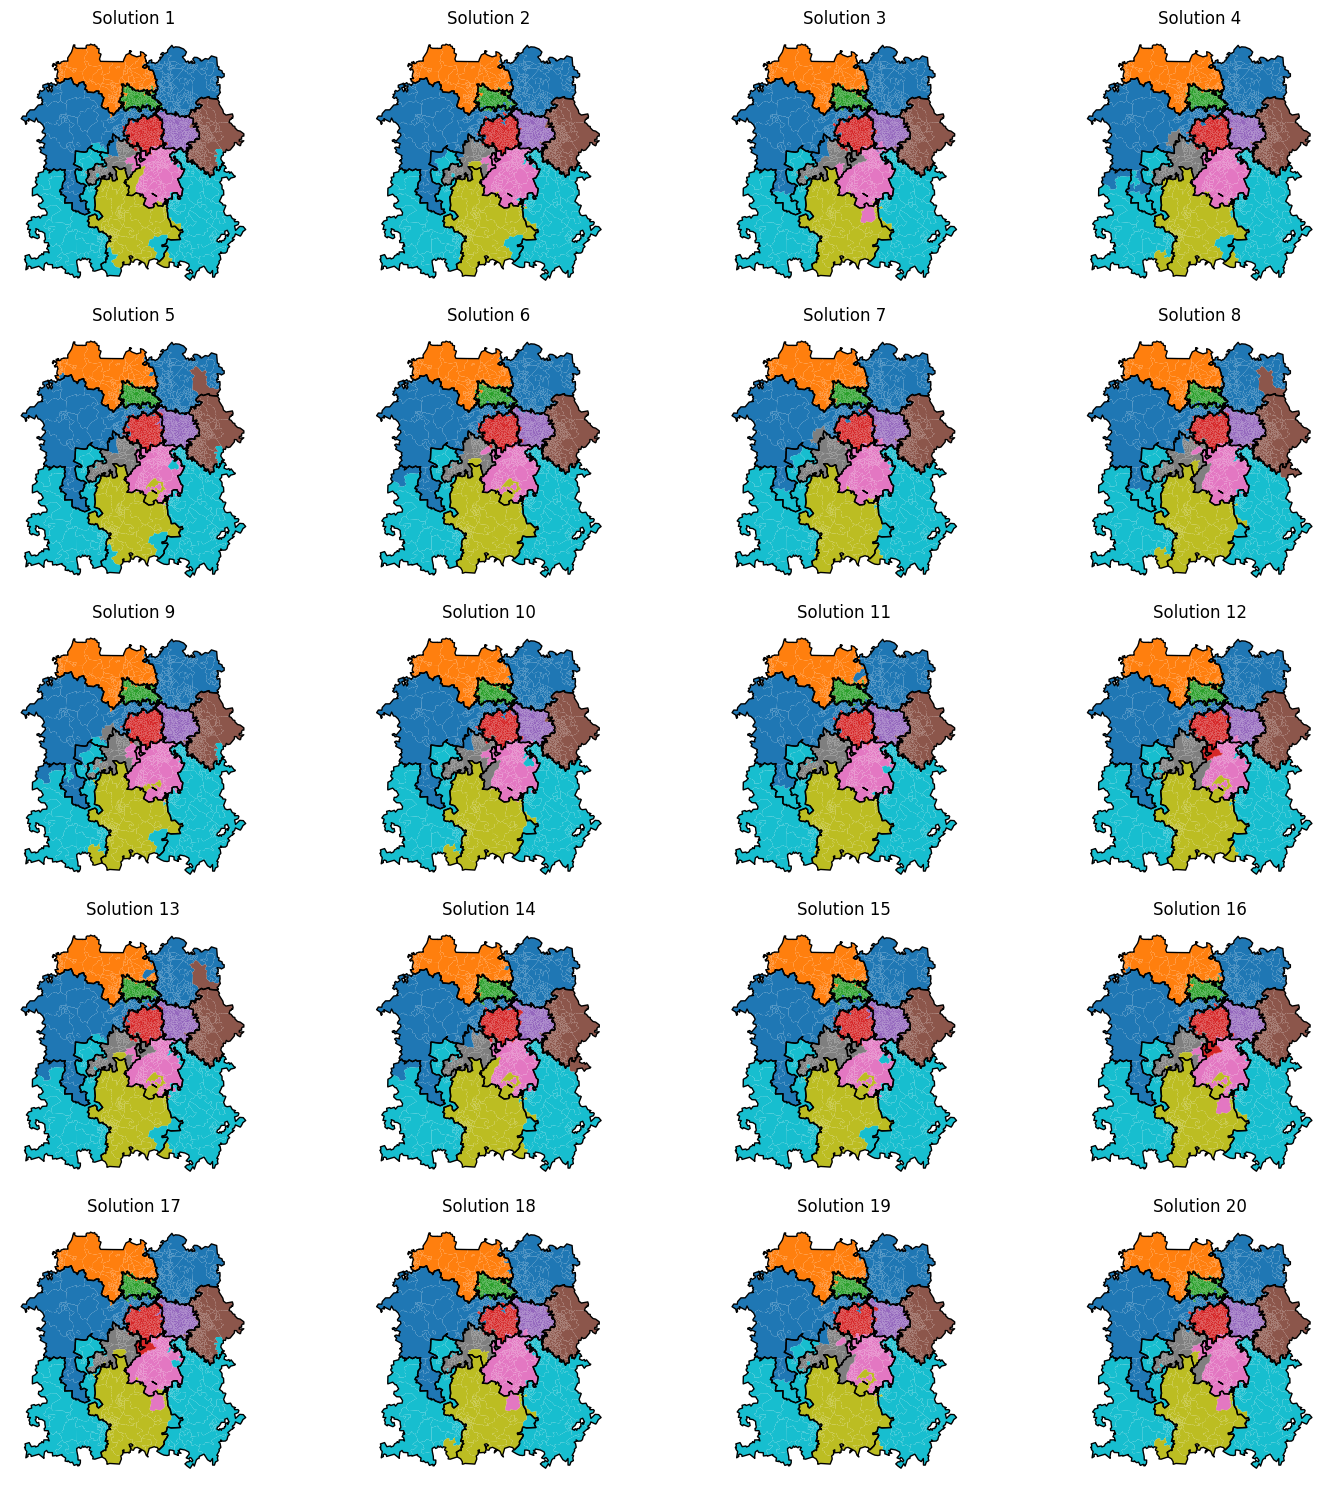

In [72]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of a 2D array of axes

for i, df in enumerate(solution[:20]):
    ax = axes[i]

    df.plot(column="centre_dispatcher_evolved",
                                              ax=ax, legend=False)

    # Plot historical boundaries
    grouped_dispatcher_gdf_starting_solution.plot(ax=ax, linewidth=1, edgecolor="black")

    ax.set_title(f"Solution {i+1}")
    ax.axis("off")  # Hide axes for better visualization

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Evaluating solution

Now let's evaluate our evolved solutions.

### Evaluation functions from previous chapter

In [ ]:
def evaluate_solution(gdf,
                      allocation_column='centre_dispatcher_NEW',
                      demand_column="demand"):
    grouped_by_dispatcher = gdf.groupby(allocation_column)[[demand_column]].sum()
    mean_demand = grouped_by_dispatcher['demand'].mean()

    grouped_by_dispatcher['difference_from_mean'] = (grouped_by_dispatcher['demand'] - mean_demand).astype('int')

    return abs(grouped_by_dispatcher['difference_from_mean']).mean().round(1)

def evaluate_solution_dict(solution_dict, gdf,
                            allocation_column='centre_dispatcher',
                            demand_column="demand", territory_unit_column="LSOA11CD"):

    owned_territory_df = pd.DataFrame(
            [(key, value) for key, values in solution_dict.items() for value in values],
            columns=[f"{allocation_column}_NEW", territory_unit_column])
    gdf = pd.merge(gdf, owned_territory_df, on=territory_unit_column, how="left")

    grouped_by_dispatcher = gdf.groupby(f"{allocation_column}_NEW")[[demand_column]].sum()
    mean_demand = grouped_by_dispatcher['demand'].mean()

    grouped_by_dispatcher['difference_from_mean'] = (grouped_by_dispatcher['demand'] - mean_demand).astype('int')

    return abs(grouped_by_dispatcher['difference_from_mean']).mean().round(1)

In [75]:
initial_solution_df.sort_values('rank')

,solution,allocations,result,rank
9,10,"{'Centre 2-5': ['E01031187', 'E01031195', 'E01...",9651.1,1.0
5,6,"{'Centre 2-5': ['E01031187', 'E01031218', 'E01...",9842.8,2.0
14,15,"{'Centre 2-5': ['E01031187', 'E01031208', 'E01...",10811.3,3.0
6,7,"{'Centre 2-5': ['E01031187', 'E01031218', 'E01...",10869.2,4.0
10,11,"{'Centre 2-5': ['E01031187', 'E01031204', 'E01...",11043.4,5.0
8,9,"{'Centre 2-5': ['E01031187', 'E01031208', 'E01...",11218.6,6.0
17,18,"{'Centre 2-5': ['E01031187', 'E01031195', 'E01...",11401.2,7.0
7,8,"{'Centre 2-5': ['E01031187', 'E01031218', 'E01...",12088.3,8.0
1,2,"{'Centre 2-5': ['E01031187', 'E01031204', 'E01...",12226.2,9.0
4,5,"{'Centre 2-5': ['E01031187', 'E01031204', 'E01...",12399.0,10.0


In [86]:
evaluate_solution(solution[0].merge(demand, on="LSOA11CD"), allocation_column="centre_dispatcher_evolved")

9753.6

In [99]:
evaluations_evolved_solutions = []

for i, sol in enumerate(solution):
    allocation_evaluation = evaluate_solution(sol.merge(demand, on="LSOA11CD"), allocation_column="centre_dispatcher_evolved")

    evaluations_evolved_solutions.append({
        'solution': f"e{i+1}",
        # We can't just pass the dictionary here due to the way python handles dictionaries
        # We need to explicitly take a copy of the dictionary
        'allocations': copy.deepcopy(sol.groupby('centre_dispatcher_evolved')['LSOA11CD'].apply(list).to_dict()),
        'result': allocation_evaluation
    })

evolution_solution_df = pd.DataFrame(evaluations_evolved_solutions)
evolution_solution_df['rank'] = evolution_solution_df['result'].rank(method='max')

evolution_solution_df.sort_values('rank')

,solution,allocations,result,rank
16,e17,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9100.4,1.0
29,e30,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9256.1,2.0
1,e2,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9372.8,3.0
26,e27,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9386.1,4.0
13,e14,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9401.9,5.0
11,e12,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9424.2,6.0
3,e4,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9493.2,7.0
20,e21,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9503.8,8.0
12,e13,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9528.8,9.0
14,e15,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9550.1,10.0


In [105]:
initial_solution_df['what'] = 'random'
evolution_solution_df['what'] = 'evolved'

full_sol_df = pd.concat([initial_solution_df, evolution_solution_df])
full_sol_df['rank'] = full_sol_df['result'].rank(method='max')
full_sol_df.sort_values('rank')

,solution,allocations,result,rank,what
16,e17,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9100.4,1.0,evolved
29,e30,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9256.1,2.0,evolved
1,e2,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9372.8,3.0,evolved
26,e27,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9386.1,4.0,evolved
13,e14,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9401.9,5.0,evolved
11,e12,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9424.2,6.0,evolved
3,e4,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9493.2,7.0,evolved
20,e21,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9503.8,8.0,evolved
12,e13,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9528.8,9.0,evolved
14,e15,"{'Centre 1-1': ['E01009742', 'E01009745', 'E01...",9550.1,10.0,evolved


In [111]:
import plotly.express as px
import pandas as pd

# Sort by 'result' to ensure correct order
full_sol_df = full_sol_df.sort_values("result", ascending=True)

# Convert 'solution' to a string (if it's not already)
full_sol_df["solution"] = full_sol_df["solution"].astype(str)

# Create the plot and enforce sorted order
fig = px.bar(
    full_sol_df,
    x="solution",
    y="result",
    color="what",
    category_orders={"solution": full_sol_df["solution"].tolist()}  # Enforce order
)

fig.show()
